In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.patches import Ellipse, Circle
import time
from itertools import islice
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torchvision
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from itertools import groupby
from operator import itemgetter
import json 

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)


steps = 10000

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

device = "mps" if torch.backends.mps.is_available() else "cpu"
print("device is:", device)

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

#torch.set_default_tensor_type(torch.DoubleTensor)


class BioLinear2D(nn.Module):

    def __init__(self, in_dim, out_dim, in_fold=1, out_fold=1, out_ring=False):
        super(BioLinear2D, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear = nn.Linear(in_dim, out_dim)
        self.in_fold = in_fold
        self.out_fold = out_fold
        assert in_dim % in_fold == 0
        assert out_dim % out_fold == 0

        #compute in_cor, shape: (in_dim_sqrt, in_dim_sqrt)
        in_dim_fold = int(in_dim/in_fold)
        out_dim_fold = int(out_dim/out_fold)
        in_dim_sqrt = int(np.sqrt(in_dim_fold))
        out_dim_sqrt = int(np.sqrt(out_dim_fold))
        x = np.linspace(1/(2*in_dim_sqrt), 1-1/(2*in_dim_sqrt), num=in_dim_sqrt)
        X, Y = np.meshgrid(x, x)
        self.in_coordinates = torch.tensor(np.transpose(np.array([X.reshape(-1,), Y.reshape(-1,)])), dtype=torch.float)

        # compute out_cor, shape: (out_dim_sqrt, out_dim_sqrt)
        if out_ring:
            thetas = np.linspace(1/(2*out_dim_fold)*2*np.pi, (1-1/(2*out_dim_fold))*2*np.pi, num=out_dim_fold)
            self.out_coordinates = 0.5+torch.tensor(np.transpose(np.array([np.cos(thetas), np.sin(thetas)]))/4, dtype=torch.float)
        else:
            x = np.linspace(1/(2*out_dim_sqrt), 1-1/(2*out_dim_sqrt), num=out_dim_sqrt)
            X, Y = np.meshgrid(x, x)
            self.out_coordinates = torch.tensor(np.transpose(np.array([X.reshape(-1,), Y.reshape(-1,)])), dtype=torch.float)


    def forward(self, x):
        return self.linear(x)


class BioMLP2D(nn.Module):
    def __init__(self, in_dim=2, out_dim=2, w=2, depth=2, shp=None, token_embedding=False, embedding_size=None):
        super(BioMLP2D, self).__init__()
        if shp == None:
            shp = [in_dim] + [w]*(depth-1) + [out_dim]
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.depth = depth

        else:
            self.in_dim = shp[0]
            self.out_dim = shp[-1]
            self.depth = len(shp) - 1
        linear_list = []
        for i in range(self.depth):
            if i == 0:
                # for modular addition
                #linear_list.append(BioLinear(shp[i], shp[i+1], in_fold=2))
                # for regression
                linear_list.append(BioLinear2D(shp[i], shp[i+1], in_fold=1).to(device))
            elif i == self.depth - 1:
                linear_list.append(BioLinear2D(shp[i], shp[i+1], in_fold=1, out_ring=True).to(device))
            else:
                linear_list.append(BioLinear2D(shp[i], shp[i+1]).to(device))
        self.linears = nn.ModuleList(linear_list)


        if token_embedding == True:
            # embedding size: number of tokens * embedding dimension
            self.embedding = torch.nn.Parameter(torch.normal(0,1,size=embedding_size)).to(device)

        self.shp = shp
        # parameters for the bio-inspired trick
        self.l0 = 0.5 # distance between two nearby layers
        self.in_perm = nn.Parameter(torch.tensor(np.arange(int(self.in_dim/self.linears[0].in_fold)), dtype=torch.float))
        self.out_perm = nn.Parameter(torch.tensor(np.arange(int(self.out_dim/self.linears[-1].out_fold)), dtype=torch.float))
        self.top_k = 30
        self.token_embedding = token_embedding

    def forward(self, x):
        shp = x.shape
        x = x.reshape(shp[0],-1)
        shp = x.shape
        in_fold = self.linears[0].in_fold
        x = x.reshape(shp[0], in_fold, int(shp[1]/in_fold))
        x = x[:,:,self.in_perm.long()]
        x = x.reshape(shp[0], shp[1])
        f = torch.nn.SiLU()
        for i in range(self.depth-1):
            x = f(self.linears[i](x))
        x = self.linears[-1](x)

        out_perm_inv = torch.zeros(self.out_dim, dtype=torch.long)
        out_perm_inv[self.out_perm.long()] = torch.arange(self.out_dim)
        x = x[:,out_perm_inv]
        #x = x[:,self.out_perm]

        return x

    def get_linear_layers(self):
        return self.linears

    def get_cc(self, weight_factor=2.0, bias_penalize=True, no_penalize_last=False):
        # compute connection cost
        cc = 0
        num_linear = len(self.linears)
        for i in range(num_linear):
            if i == num_linear - 1 and no_penalize_last:
                weight_factor = 0.
            biolinear = self.linears[i].to(device)
            dist = torch.sum(torch.abs(biolinear.out_coordinates.unsqueeze(dim=1) - biolinear.in_coordinates.unsqueeze(dim=0)),dim=2).to(device)
            # print("yooo")
            # print(biolinear.linear.weight.device)
            # print(dist.device)
            # print(self.l0)
            cc += torch.mean(torch.abs(biolinear.linear.weight)*(weight_factor*dist+self.l0))
            if bias_penalize == True:
                cc += torch.mean(torch.abs(biolinear.linear.bias)*(self.l0))
        if self.token_embedding:
            cc += torch.mean(torch.abs(self.embedding)*(self.l0))
            #pass
        return cc

    def swap_weight(self, weights, j, k, swap_type="out"):
        with torch.no_grad():
            if swap_type == "in":
                temp = weights[:,j].clone()
                weights[:,j] = weights[:,k].clone()
                weights[:,k] = temp
            elif swap_type == "out":
                temp = weights[j].clone()
                weights[j] = weights[k].clone()
                weights[k] = temp
            else:
                raise Exception("Swap type {} is not recognized!".format(swap_type))

    def swap_bias(self, biases, j, k):
        with torch.no_grad():
            temp = biases[j].clone()
            biases[j] = biases[k].clone()
            biases[k] = temp

    def swap(self, i, j, k):
        # in the ith layer (of neurons), swap the jth and the kth neuron.
        # Note: n layers of weights means n+1 layers of neurons.
        # (incoming, outgoing) * weights + biases are swapped.
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            return
            # for images, do not allow input_perm
            # input layer, only has outgoing weights; update in_perm
            weights = linears[i].linear.weight
            infold = linears[i].in_fold
            fold_dim = int(weights.shape[1]/infold)
            for l in range(infold):
                self.swap_weight(weights, j+fold_dim*l, k+fold_dim*l, swap_type="in")
            # change input_perm. do not allow input_perm for images
            self.swap_bias(self.in_perm, j, k)
        elif i == num_linear:
            # output layer, only has incoming weights and biases; update out_perm
            weights = linears[i-1].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights, j, k, swap_type="out")
            self.swap_bias(biases, j, k)
            # change output_perm
            self.swap_bias(self.out_perm, j, k)
        else:
            # middle layer : (incoming, outgoing) * weights, and biases
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights_in, j, k, swap_type="out")
            self.swap_weight(weights_out, j, k, swap_type="in")
            self.swap_bias(biases, j, k)

    def get_top_id(self, i, top_k=20):
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer
            weights = linears[i].linear.weight
            score = torch.sum(torch.abs(weights), dim=0)
            in_fold = linears[0].in_fold
            #print(score.shape)
            score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
        elif i == num_linear:
            # output layer
            weights = linears[i-1].linear.weight
            score = torch.sum(torch.abs(weights), dim=1)
        else:
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
        #print(score.shape)
        top_index = torch.flip(torch.argsort(score),[0])[:top_k]
        return top_index, score

    def relocate_ij(self, i, j):
        # In the ith layer (of neurons), relocate the jth neuron
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i < num_linear:
            num_neuron = int(linears[i].linear.weight.shape[1]/linears[i].in_fold)
        else:
            num_neuron = linears[i-1].linear.weight.shape[0]
        ccs = []
        for k in range(num_neuron):
            self.swap(i,j,k)
            ccs.append(self.get_cc())
            self.swap(i,j,k)
        k = torch.argmin(torch.stack(ccs))
        self.swap(i,j,k)

    def relocate_i(self, i):
        # Relocate neurons in the ith layer
        top_id = self.get_top_id(i, top_k=self.top_k)
        for j in top_id[0]:
            self.relocate_ij(i,j)

    def relocate(self):
        # Relocate neurons in the whole model
        linears = self.get_linear_layers()
        num_linear = len(linears)
        for i in range(num_linear+1):
            self.relocate_i(i)



/Users/zephyr/anaconda3/envs/modmi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device is: mps


In [2]:
train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)
data_size = 60000
train = torch.utils.data.Subset(train, range(data_size))
train_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 18342077.19it/s]


Extracting /tmp/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 2380951.98it/s]

Extracting /tmp/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 5529744.75it/s]


Extracting /tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 654477.42it/s]

Extracting /tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/MNIST/raw



In [ ]:
# mlp = BioMLP2D(shp=(784,100,100,10)).to("cpu")
# mlp.load_state_dict(torch.load('fivemodels/bimt.pt'))

In [3]:
def extract_activations(layer, input, output):
    return output

activations = []

def hook_fn(module, input, output):
    activations.append(output)

hooks = []

def measure_improvement(patched_logits, original_logits):
    # Compute L2 difference
    difference_L2 = torch.norm(patched_logits - original_logits, p=2).item()
    return difference_L2

def patch_neuron(activation, neuron_idx, new_value):
    patched_activation = activation.clone()
    # print("To be patched: ", patched_activation[0, neuron_idx])
    # print("patched to:", new_value)
    patched_activation[0, neuron_idx] = new_value
    return patched_activation

def sparsify2circuit_left(wt_tensor, indices_tensor):
    zero_tensor = torch.zeros_like(wt_tensor)
    zero_tensor[indices_tensor, :] = wt_tensor[indices_tensor, :]
    return zero_tensor

def sparsify2circuit_right(wt_tensor, indices_tensor):
    zero_tensor = torch.zeros_like(wt_tensor)
    zero_tensor[:, indices_tensor] = wt_tensor[:, indices_tensor]
    return zero_tensor

def get_top_n_from_each_layer(layer_dict, n):
    # top_n = {}
    top_try = {}
    for layer in layer_dict:
        # top_n[layer] = layer_dict[layer][:n]
        top_try[layer] = [z[0][1] for z in layer_dict[layer][:n]]
    return top_try

def circuit_discovery(model, clean_tensor, corr_tensor):

    # Attach hooks to all BioLinear2D layers
    for layer in model.get_linear_layers():
        hooks.append(layer.register_forward_hook(hook_fn))

    model.eval() 
    original_output = model(clean_tensor)
    clean_activations = activations.copy()  # Store activations after passing the clean tensor
    activations.clear()
    # print(clean_activations)
    model(corr_tensor)
    corrupted_activations = activations  # Store activations after passing the corrupted tensor
    # print(corrupted_activations)

    # Clear the hooks
    for hook in hooks:
        hook.remove()

    improvements = []

    # Iterate through layers
    for layer_idx, (clean_act, corrupted_act) in enumerate(zip(clean_activations, corrupted_activations)):
        num_neurons = clean_act.shape[1]
        
        for neuron_idx in range(num_neurons):
            # Patch the neuron in the corrupted activations
            patched_act = patch_neuron(corrupted_act, neuron_idx, clean_act[0, neuron_idx])

            # Store the patched activations and keep others as-is
            current_activations = [a.clone() for a in corrupted_activations]
            current_activations[layer_idx] = patched_act
            model.eval() 

            for inn_idx, sub_layer in enumerate(model.get_linear_layers()[layer_idx+1:]):
                current_activations[layer_idx+inn_idx+1] = sub_layer(current_activations[layer_idx+inn_idx])

            improvement = measure_improvement(current_activations[-1], original_output)  # Implement measure_improvement as required
            improvements.append((layer_idx, neuron_idx, improvement))

    sorted_neurons = sorted(improvements, key=lambda x: x[2], reverse=False)
    return sorted_neurons


In [50]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)

# Create datasets for each class
class_3_dataset = [(image, label) for image, label in train_dataset if label == 3]
class_5_dataset = [(image, label) for image, label in train_dataset if label == 5]
class_6_dataset = [(image, label) for image, label in train_dataset if label == 6]
class_8_dataset = [(image, label) for image, label in train_dataset if label == 8]

class_1_dataset = [(image, label) for image, label in train_dataset if label == 1]
class_4_dataset = [(image, label) for image, label in train_dataset if label == 4]
class_7_dataset = [(image, label) for image, label in train_dataset if label == 7]
class_9_dataset = [(image, label) for image, label in train_dataset if label == 9]

# 1 3

# 4 9

# 7 9

# 1 2 3 4 5 6 7 8 9 0
# class_8_dataset = [(image, label) for image, label in train_dataset if label == 8]

# Custom dataset for paired data
class PairedDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __len__(self):
        # Ensure both datasets are of the same length
        return min(len(self.dataset1), len(self.dataset2))

    def __getitem__(self, idx):
        image1, _ = self.dataset1[idx % len(self.dataset1)]
        image2, _ = self.dataset2[idx % len(self.dataset2)]
        return image1, image2

paired_dataset_1_3 = PairedDataset(class_3_dataset, class_1_dataset)
paired_dataset_4_9 = PairedDataset(class_9_dataset, class_4_dataset)
paired_dataset_7_9 = PairedDataset(class_9_dataset, class_7_dataset)
# Create the paired datasets
paired_dataset_3_8 = PairedDataset(class_3_dataset, class_8_dataset)
paired_dataset_5_6 = PairedDataset(class_5_dataset, class_6_dataset)

# Combine the paired datasets
final_dataset = paired_dataset_3_8 + paired_dataset_5_6

# Create a DataLoader for the final dataset
final_loader = DataLoader(final_dataset, batch_size=1, shuffle=True)
# loader_3_8 = DataLoader(paired_dataset_3_8, batch_size=1, shuffle=True)

final_st = paired_dataset_1_3 + paired_dataset_4_9 + paired_dataset_7_9
st_loader = DataLoader(final_st, batch_size=1, shuffle=True)


# # Example: Iterate over the DataLoader
# for i, (image1, image2) in enumerate(final_loader):
#     print(f"Batch {i}:")
#     print("Image from Class 3/5:", image1.shape)
#     print("Image from Class 6/8:", image2.shape)
#     if i == 5:  # Stop after 6 iterations for demonstration
#         break


In [52]:
from torch.utils.data import DataLoader, Subset
import random
import gc

def subset_discovery(mlp, model_path, subset_size, dataset):
    # subset_size = 500  # or any size you deem appropriate
    subset_indices = random.sample(range(len(dataset)), subset_size)
    subset = Subset(dataset, subset_indices)
    # Create a DataLoader for the subset
    subset_loader = DataLoader(subset, batch_size=1, shuffle=True)

    value_dict = defaultdict(lambda: {'sum': 0, 'count': 0})
    start = time.time()
    for i, (image1, image2) in enumerate(subset_loader):
        sorted_neurons =  circuit_discovery(mlp, image2, image1)
        for layer, neuron, value in sorted_neurons:
            value_dict[(layer, neuron)]['sum'] += value
            value_dict[(layer, neuron)]['count'] += 1

    average_values = {}
    for key, data in value_dict.items():
        average = data['sum'] / data['count']
        average_values[key] = average

    data = average_values
    # Separate the dictionary for each layer and sort according to the logit value
    layer_dict = {}
    for (layer, neuron), logit in data.items():
        if layer not in layer_dict:
            layer_dict[layer] = []
        layer_dict[layer].append(((layer, neuron), logit))

        # Sort each layer's list by logit value in descending order
    for layer in layer_dict:
        layer_dict[layer].sort(key=lambda x: x[1], reverse=False)

        # stop = 
    top_15 = get_top_n_from_each_layer(layer_dict, 25)
    # model_result[val] = top_15
    stop_time = time.time()-start
    print("Model: ", model_path)
    print("Time to discover circuit: ", time.time()-start)

    avg_logit_diff = 0
    for i, (image1, image2) in enumerate(subset_loader):
        clean_tensor = image2
        mlp.eval()
        with torch.no_grad():
            og_op = mlp(clean_tensor)
            clean_activations = activations.copy()

        sub_graph_act = [a.clone() for a in clean_activations]

        for inn_idx, sub_layer in enumerate(mlp.get_linear_layers()[1:]):
            # print(inn_idx+layer_idx)
            zero_tensor = torch.zeros_like(sub_graph_act[inn_idx])
            zero_tensor[0, torch.tensor(top_15[inn_idx])] = sub_graph_act[inn_idx][0, torch.tensor(top_15[inn_idx])]
            sub_graph_act[inn_idx] = zero_tensor
            # print(sub_graph_act[inn_idx].shape)
            sub_graph_act[inn_idx+1] = sub_layer(sub_graph_act[inn_idx])

        avg_logit_diff += measure_improvement(sub_graph_act[-1], og_op)
        # break
    avg_logit_diff = avg_logit_diff/len(subset_loader)
    print("Average Logit Diff: ", avg_logit_diff)

    avg_spar = 0
    for ii in range(3):
        biolinear = mlp.linears[ii]
        p = biolinear.linear.weight.clone()
        if ii == 0:
            p = sparsify2circuit_left(p, torch.tensor(top_15[ii]))
        else:
            p = sparsify2circuit_right(p, torch.tensor(top_15[ii]))
            p = sparsify2circuit_left(p, torch.tensor(top_15[ii]))

        W = p.T.detach().numpy()
        n_sparsity = (np.abs(W)<0.0009).sum()
        avg_spar+=n_sparsity/(W.shape[0]*W.shape[1])
        # print("Percentage Sparsity:", n_sparsity/(W.shape[0]*W.shape[1]))
    avg_spar = avg_spar/3
    print("Average Sparsity: ", avg_spar)
    
    return [top_15, avg_logit_diff, stop_time, avg_spar]
            
        # Run circuit discovery on the bootstrap sample
        # top_15_neurons, avg_logit_diff, stop_time, sparsity = circuit_discovery(mlp, subset_loader)

        # Store the results
        

In [5]:
models = ["fivemodels/bimt.pt", "fivemodels/l1local.pt", "fivemodels/l1only.pt", "fivemodels/l1swap.pt", "fivemodels/fully_dense.pt"]

In [51]:
st_loader

In [54]:
from torch.utils.data import DataLoader, Subset
import random
import gc

# Assuming you have a function `circuit_discovery` that returns top_15_neurons, avg_logit_diff, stop_time, sparsity
# def circuit_discovery(model, data_loader): ...

# Your DataLoader and models setup remains the same
final_loader = DataLoader(final_dataset, batch_size=1, shuffle=True)
# models = ["fivemodels/bimt.pt", "fivemodels/l1local.pt", "fivemodels/l1only.pt", "fivemodels/l1swap.pt", "fivemodels/fully_dense.pt"]
models = ["fivemodels/bimt.pt", "fivemodels/l1local.pt", "fivemodels/l1only.pt", "fivemodels/l1swap.pt", "fivemodels/fully_dense.pt"]

# Number of bootstrap samples
n_bootstrap_samples = 20  # or any other number you deem sufficient

model_result = {}
for val, model_path in enumerate(models):
    mlp = BioMLP2D(shp=(784,100,100,10)).to("cpu")
    mlp.load_state_dict(torch.load(model_path))

    # Prepare to collect bootstrap results
    bootstrap_results = {'top_15': [], 'avg_logit_diff': [], 'stop_time': [], 'sparsity': []}
    subset_size = 100
    for _ in range(n_bootstrap_samples):
        # subset_indices = random.sample(range(len(final_dataset)), 1000)
        # subset = Subset(final_dataset, subset_indices)
        # # Create a DataLoader for the subset
        # subset_loader = DataLoader(subset, batch_size=1, shuffle=True)
        
        subset_results = subset_discovery(mlp, model_path, subset_size, final_st)    
        # Run circuit discovery on the bootstrap sample
        # top_15_neurons, avg_logit_diff, stop_time, sparsity = circuit_discovery(mlp, subset_loader)

        # Store the results
        bootstrap_results['top_15'].append(subset_results[0])
        bootstrap_results['avg_logit_diff'].append(subset_results[1])
        bootstrap_results['stop_time'].append(subset_results[2])
        bootstrap_results['sparsity'].append(subset_results[3])
        gc.collect()
        print("-"*20)

    # Store results for this model
    print("Done with ", model_path)
    model_result[val] = bootstrap_results
    with open('model_results_st.json', 'w') as json_file:
        json.dump(model_result, json_file)

# After this, model_result will have the bootstrap distributions for each metric for each model


Model:  fivemodels/bimt.pt
Time to discover circuit:  8.460631132125854
Average Logit Diff:  1.5535548198223115
Average Sparsity:  0.9835238095238096
--------------------
Model:  fivemodels/bimt.pt
Time to discover circuit:  8.432724952697754
Average Logit Diff:  1.1567475670576095
Average Sparsity:  0.9875960884353742
--------------------
Model:  fivemodels/bimt.pt
Time to discover circuit:  8.433588981628418
Average Logit Diff:  0.931290403008461
Average Sparsity:  0.9839163265306122
--------------------
Model:  fivemodels/bimt.pt
Time to discover circuit:  8.439559936523438
Average Logit Diff:  0.9008853617310524
Average Sparsity:  0.9857227891156463
--------------------
Model:  fivemodels/bimt.pt
Time to discover circuit:  8.456236124038696
Average Logit Diff:  1.1365771555900575
Average Sparsity:  0.9856134353741496
--------------------
Model:  fivemodels/bimt.pt
Time to discover circuit:  8.431932210922241
Average Logit Diff:  0.9797960150241852
Average Sparsity:  0.9858933673469

In [55]:
import numpy as np
import scipy.stats as stats

def mean_confidence_interval(data):
    n = len(data)
    mean = np.mean(data)
    std_err = stats.sem(data)
    h = std_err * stats.t.ppf((1 + 0.95) / 2, n - 1)  # 95% CI

    return mean, h # mean - h, mean + h

metrics = ["avg_logit_diff", "stop_time", "sparsity"]

avg_results = {}

for i in range(5):
    temp = {}
    for met in metrics:
        mean, h = mean_confidence_interval(model_result[i][met])
        # print(f"Model: {models[i]}, metric: {met}: Mean = {mean}, 95% CI = ({ci_lower}, {ci_upper})")
        temp[met] = [mean, h]
        # print(model_result[i]["avg_logit_diff"])
        # print(model_result[i]["stop_time"])
        # print(model_result[i]["sparsity"])
        # print("-"*20
    avg_results[models[i]] = temp

print(avg_results)

{'fivemodels/bimt.pt': {'avg_logit_diff': [1.3281621509492398, 0.30065939075883985], 'stop_time': [8.453461146354675, 0.007918620268235272], 'sparsity': [0.9839527806122449, 0.0013898862397499897]}, 'fivemodels/l1local.pt': {'avg_logit_diff': [1.4663056277781723, 0.3158338925922389], 'stop_time': [8.647523629665375, 0.1009415653694821], 'sparsity': [0.98147425170068, 0.0008743501029641102]}, 'fivemodels/l1only.pt': {'avg_logit_diff': [1.382896779835224, 0.27016060535554876], 'stop_time': [8.607308506965637, 0.02072031233563043], 'sparsity': [0.955866462585034, 0.0003942105365294669]}, 'fivemodels/l1swap.pt': {'avg_logit_diff': [1.691388753671199, 0.38077573429620404], 'stop_time': [8.689433383941651, 0.032214451386828075], 'sparsity': [0.9584242517006804, 0.00031917964373040855]}, 'fivemodels/fully_dense.pt': {'avg_logit_diff': [7.121328021347523, 1.5863204516236806], 'stop_time': [8.652990436553955, 0.010286117643608305], 'sparsity': [0.8635901445578231, 1.7738419765758813e-05]}}


In [58]:
for k in avg_results.keys():
    print(avg_results[k])
    print("-------")

{'avg_logit_diff': [1.3281621509492398, 0.30065939075883985], 'stop_time': [8.453461146354675, 0.007918620268235272], 'sparsity': [0.9839527806122449, 0.0013898862397499897]}
-------
{'avg_logit_diff': [1.4663056277781723, 0.3158338925922389], 'stop_time': [8.647523629665375, 0.1009415653694821], 'sparsity': [0.98147425170068, 0.0008743501029641102]}
-------
{'avg_logit_diff': [1.382896779835224, 0.27016060535554876], 'stop_time': [8.607308506965637, 0.02072031233563043], 'sparsity': [0.955866462585034, 0.0003942105365294669]}
-------
{'avg_logit_diff': [1.691388753671199, 0.38077573429620404], 'stop_time': [8.689433383941651, 0.032214451386828075], 'sparsity': [0.9584242517006804, 0.00031917964373040855]}
-------
{'avg_logit_diff': [7.121328021347523, 1.5863204516236806], 'stop_time': [8.652990436553955, 0.010286117643608305], 'sparsity': [0.8635901445578231, 1.7738419765758813e-05]}
-------


In [22]:
for i, txt in enumerate(models):
    t = txt.split("/")[-1].split('.')[0]
    print(t)


bimt
l1local
l1only
l1swap
fully_dense


In [59]:
with open('bootstrap_st.json', 'w') as json_file:
    json.dump(avg_results, json_file)

In [41]:
for k,v in avg_results.items():
    v["stop_time"] = v["stop_time"]*10

for k,v in avg_results.items():
    print(v)

{'avg_logit_diff': [1.2737224330881716, 0.18334597917278106], 'stop_time': [9.376142251491547, 0.021555709196431627, 9.376142251491547, 0.021555709196431627, 9.376142251491547, 0.021555709196431627, 9.376142251491547, 0.021555709196431627, 9.376142251491547, 0.021555709196431627, 9.376142251491547, 0.021555709196431627, 9.376142251491547, 0.021555709196431627, 9.376142251491547, 0.021555709196431627, 9.376142251491547, 0.021555709196431627, 9.376142251491547, 0.021555709196431627], 'sparsity': [0.9859922108843537, 0.0009761369140441251]}
{'avg_logit_diff': [1.7953282489763893, 0.2892961738550312], 'stop_time': [9.431681668758392, 0.032933812391417676, 9.431681668758392, 0.032933812391417676, 9.431681668758392, 0.032933812391417676, 9.431681668758392, 0.032933812391417676, 9.431681668758392, 0.032933812391417676, 9.431681668758392, 0.032933812391417676, 9.431681668758392, 0.032933812391417676, 9.431681668758392, 0.032933812391417676, 9.431681668758392, 0.032933812391417676, 9.4316816687

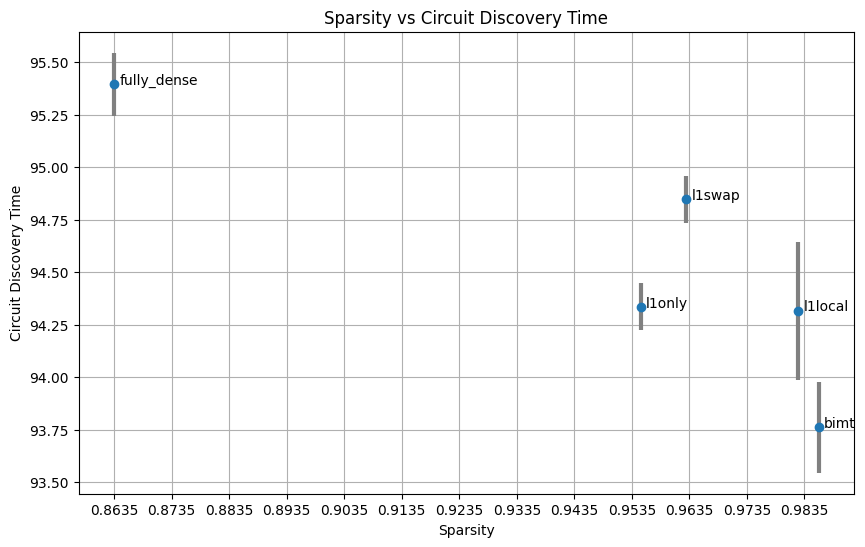

In [38]:
import matplotlib.pyplot as plt
import numpy as np

data = avg_results

# Extracting the values for plotting
models = list(data.keys())
avg_logit_diff_values = [data[model]['avg_logit_diff'][0] for model in models]
avg_logit_diff_errors = [data[model]['avg_logit_diff'][1] for model in models]

time_values = [data[model]['stop_time'][0]*10 for model in models]
time_errors = [data[model]['stop_time'][1]*10 for model in models]

sparsity_values = [data[model]['sparsity'][0] for model in models]
sparsity_errors = [data[model]['sparsity'][1] for model in models]

# Plotting
plt.figure(figsize=(10, 6))
# plt.errorbar(sparsity_values, avg_logit_diff_values, xerr=sparsity_errors, yerr=avg_logit_diff_errors, fmt='o', ecolor='gray', elinewidth=3, capsize=0)
plt.errorbar(sparsity_values, time_values, yerr=time_errors, fmt='o', ecolor='gray', elinewidth=3, capsize=0)

# Labeling
plt.xlabel('Sparsity')
plt.ylabel('Circuit Discovery Time')
plt.title('Sparsity vs Circuit Discovery Time')
plt.xticks(np.arange(min(sparsity_values), max(sparsity_values), 0.01))
plt.grid(True)

# Annotating the models
for i, txt in enumerate(models):
    t = txt.split("/")[-1].split('.')[0]
    plt.annotate(t, (sparsity_values[i]+0.0009, time_values[i]))

plt.show()

In [60]:
import json

# Replace 'path_to_file.json' with the path to your JSON file
file_path = 'bootstrap_st.json'

# Open the JSON file and load its contents into a Python object
with open(file_path, 'r') as file:
    data = json.load(file)

# Now 'data' is a Python object containing the data from the JSON file
print(data)

{'fivemodels/bimt.pt': {'avg_logit_diff': [1.3281621509492398, 0.30065939075883985], 'stop_time': [8.453461146354675, 0.007918620268235272], 'sparsity': [0.9839527806122449, 0.0013898862397499897]}, 'fivemodels/l1local.pt': {'avg_logit_diff': [1.4663056277781723, 0.3158338925922389], 'stop_time': [8.647523629665375, 0.1009415653694821], 'sparsity': [0.98147425170068, 0.0008743501029641102]}, 'fivemodels/l1only.pt': {'avg_logit_diff': [1.382896779835224, 0.27016060535554876], 'stop_time': [8.607308506965637, 0.02072031233563043], 'sparsity': [0.955866462585034, 0.0003942105365294669]}, 'fivemodels/l1swap.pt': {'avg_logit_diff': [1.691388753671199, 0.38077573429620404], 'stop_time': [8.689433383941651, 0.032214451386828075], 'sparsity': [0.9584242517006804, 0.00031917964373040855]}, 'fivemodels/fully_dense.pt': {'avg_logit_diff': [7.121328021347523, 1.5863204516236806], 'stop_time': [8.652990436553955, 0.010286117643608305], 'sparsity': [0.8635901445578231, 1.7738419765758813e-05]}}


In [61]:
for k,v in data.items():
    v["stop_time"][0] = v["stop_time"][0]*10
    v["stop_time"][1] = v["stop_time"][1]*10


for k,v in data.items():
    print(v)

{'avg_logit_diff': [1.3281621509492398, 0.30065939075883985], 'stop_time': [84.53461146354675, 0.07918620268235271], 'sparsity': [0.9839527806122449, 0.0013898862397499897]}
{'avg_logit_diff': [1.4663056277781723, 0.3158338925922389], 'stop_time': [86.47523629665375, 1.009415653694821], 'sparsity': [0.98147425170068, 0.0008743501029641102]}
{'avg_logit_diff': [1.382896779835224, 0.27016060535554876], 'stop_time': [86.07308506965637, 0.2072031233563043], 'sparsity': [0.955866462585034, 0.0003942105365294669]}
{'avg_logit_diff': [1.691388753671199, 0.38077573429620404], 'stop_time': [86.8943338394165, 0.32214451386828075], 'sparsity': [0.9584242517006804, 0.00031917964373040855]}
{'avg_logit_diff': [7.121328021347523, 1.5863204516236806], 'stop_time': [86.52990436553955, 0.10286117643608304], 'sparsity': [0.8635901445578231, 1.7738419765758813e-05]}


In [62]:
with open('bootstrap_st.json', 'w') as json_file:
        json.dump(data, json_file)

In [45]:
models = ["fivemodels/bimt.pt", "fivemodels/l1local.pt", "fivemodels/l1only.pt", "fivemodels/l1swap.pt", "fivemodels/fully_dense.pt"]


from torch.utils.data import DataLoader, Subset
import random
import gc

# Assuming you have a function `circuit_discovery` that returns top_15_neurons, avg_logit_diff, stop_time, sparsity
# def circuit_discovery(model, data_loader): ...

# Your DataLoader and models setup remains the same
final_loader = DataLoader(final_dataset, batch_size=1, shuffle=True)
# models = ["fivemodels/bimt.pt", "fivemodels/l1local.pt", "fivemodels/l1only.pt", "fivemodels/l1swap.pt", "fivemodels/fully_dense.pt"]
models = ["fivemodels/bimt.pt", "fivemodels/l1local.pt", "fivemodels/l1only.pt", "fivemodels/l1swap.pt", "fivemodels/fully_dense.pt"]

# Number of bootstrap samples
n_bootstrap_samples = 20  # or any other number you deem sufficient

avg_inf_time = {0:[], 1:[], 2:[], 3:[], 4:[]}
for val, model_path in enumerate(models):
    mlp = BioMLP2D(shp=(784,100,100,10)).to("cpu")
    mlp.load_state_dict(torch.load(model_path))

    for _ in range(n_bootstrap_samples):
        
        subset_indices = random.sample(range(len(final_dataset)), 1000)
        subset = Subset(final_dataset, subset_indices)
        # Create a DataLoader for the subset
        avg_inf = 0
        subset_loader = DataLoader(subset, batch_size=1, shuffle=True)
        for i, (image1, image2) in enumerate(subset_loader):
            clean_tensor = image2
            start = time.time()
            mlp.eval()
            with torch.no_grad():
                og_op = mlp(clean_tensor)
                avg_inf += time.time()-start
        avg_inf_time[val].append(avg_inf)
        # Store the results
        gc.collect()
        print("-"*20)

    # Store results for this model
    print("Done with ", model_path)
    # model_result[val] = bootstrap_results
    with open('inf.json', 'w') as json_file:
        json.dump(avg_inf_time, json_file)





--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
Done with  fivemodels/bimt.pt
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
--------------------
Done with  fivemodels/l1local.pt
--------------------
--------------------
--------------------
--------------------
-------------

In [46]:
avg_inf_time

{0: [0.07564640045166016,
  0.06342625617980957,
  0.06416988372802734,
  0.06525444984436035,
  0.07244682312011719,
  0.06749272346496582,
  0.06493568420410156,
  0.06429672241210938,
  0.0651404857635498,
  0.0650787353515625,
  0.06552338600158691,
  0.06455111503601074,
  0.06476759910583496,
  0.06479358673095703,
  0.06464099884033203,
  0.06485462188720703,
  0.06475615501403809,
  0.0646209716796875,
  0.06462812423706055,
  0.06441211700439453],
 1: [0.06493806838989258,
  0.06451249122619629,
  0.06571793556213379,
  0.06485414505004883,
  0.06523489952087402,
  0.06530356407165527,
  0.06497740745544434,
  0.06451201438903809,
  0.06500577926635742,
  0.06473088264465332,
  0.06561613082885742,
  0.06468605995178223,
  0.06493687629699707,
  0.06480216979980469,
  0.06472921371459961,
  0.06464505195617676,
  0.06466484069824219,
  0.06447505950927734,
  0.06493473052978516,
  0.06433558464050293],
 2: [0.06441187858581543,
  0.06444287300109863,
  0.06495022773742676,
  0

In [47]:
def mean_confidence_interval(data):
    n = len(data)
    mean = np.mean(data)
    std_err = stats.sem(data)
    h = std_err * stats.t.ppf((1 + 0.95) / 2, n - 1)  # 95% CI

    return mean, h # mean - h, mean + h

for k, v in avg_inf_time.items():
    print(mean_confidence_interval(v))

(0.06577184200286865, 0.0013927661991169052)
(0.06488064527511597, 0.0001699680190952522)
(0.0646560549736023, 0.00017137254463719725)
(0.06494998931884766, 0.00012326044860905294)
(0.06520644426345826, 0.0006449584712101988)


In [1]:
inference_time_data = [
    (0.06577184200286865, 0.0013927661991169052),
    (0.06488064527511597, 0.0001699680190952522),
    (0.0646560549736023, 0.00017137254463719725),
    (0.06494998931884766, 0.00012326044860905294),
    (0.06520644426345826, 0.0006449584712101988)
]

model_names = ["BIMT", "L1+Local", "L1Only", "L1+Swap", "FullyDense"]

# Extracting mean values and confidence intervals
means = [mean for mean, ci in inference_time_data]
cis = [ci for mean, ci in inference_time_data]

# Plotting
plt.figure(figsize=(10, 6))

plt.errorbar(model_names, means, yerr=cis, fmt='o', ecolor='gray', elinewidth=3, capsize=5)

# Labeling
plt.xlabel('Model Name')
plt.ylabel('Inference Time (mean ± 95% CI)')
plt.title('Inference Time for Different Models')
plt.grid(True)

plt.show()

NameError: name 'plt' is not defined

In [18]:
# models = ["fivemodels/bimt.pt", "fivemodels/l1local.pt", "fivemodels/l1only.pt", "fivemodels/l1swap.pt", "fivemodels/fully_dense.pt"]

# model_result = {}
# for val, model in enumerate(models):
#     mlp = BioMLP2D(shp=(784,100,100,10)).to("cpu")
#     mlp.load_state_dict(torch.load(model))

#     value_dict = defaultdict(lambda: {'sum': 0, 'count': 0})
#     start = time.time()
#     for i, (image1, image2) in enumerate(final_loader):
#         sorted_neurons =  circuit_discovery(mlp, image2, image1)
#         for layer, neuron, value in sorted_neurons:
#             value_dict[(layer, neuron)]['sum'] += value
#             value_dict[(layer, neuron)]['count'] += 1
#         if i % 100 == 0:
#             print("iter: ", i)

#     average_values = {}
#     for key, data in value_dict.items():
#         average = data['sum'] / data['count']
#         average_values[key] = average

#     # print(average_values.items())

#     data = average_values
#     # Separate the dictionary for each layer and sort according to the logit value
#     layer_dict = {}
#     for (layer, neuron), logit in data.items():
#         if layer not in layer_dict:
#             layer_dict[layer] = []
#         layer_dict[layer].append(((layer, neuron), logit))

#     # Sort each layer's list by logit value in descending order
#     for layer in layer_dict:
#         layer_dict[layer].sort(key=lambda x: x[1], reverse=False)

#     # stop = 
#     top_15 = get_top_n_from_each_layer(layer_dict, 25)
#     # model_result[val] = top_15
#     stop_time = time.time()-start
#     print("Model: ", model)
#     print("Time to discover circuit: ", time.time()-start)

#     avg_logit_diff = 0
#     for i, (image1, image2) in enumerate(final_loader):
#         clean_tensor = image2
#         mlp.eval()
#         with torch.no_grad():
#             og_op = mlp(clean_tensor)
#             clean_activations = activations.copy()

#         sub_graph_act = [a.clone() for a in clean_activations]

#         for inn_idx, sub_layer in enumerate(mlp.get_linear_layers()[1:]):
#             # print(inn_idx+layer_idx)
#             zero_tensor = torch.zeros_like(sub_graph_act[inn_idx])
#             zero_tensor[0, torch.tensor(top_15[inn_idx])] = sub_graph_act[inn_idx][0, torch.tensor(top_15[inn_idx])]
#             sub_graph_act[inn_idx] = zero_tensor
#             # print(sub_graph_act[inn_idx].shape)
#             sub_graph_act[inn_idx+1] = sub_layer(sub_graph_act[inn_idx])

#         avg_logit_diff += measure_improvement(sub_graph_act[-1], og_op)
#         # break
#     avg_logit_diff = avg_logit_diff/len(final_loader)
#     print("Average Logit Diff: ", avg_logit_diff)

#     for ii in range(3):
#         biolinear = mlp.linears[ii]
#         p = biolinear.linear.weight.clone()
#         if ii == 0:
#             p = sparsify2circuit_left(p, torch.tensor(model_result[val][0][ii]))
#         else:
#             p = sparsify2circuit_right(p, torch.tensor(model_result[val][0][ii]))
#             p = sparsify2circuit_left(p, torch.tensor(model_result[val][0][ii]))

#         W = p.T.detach().numpy()
#         n_sparsity = (np.abs(W)<0.0009).sum()
#         avg_spar+=n_sparsity/(W.shape[0]*W.shape[1])
#         # print("Percentage Sparsity:", n_sparsity/(W.shape[0]*W.shape[1]))
#     avg_spar = avg_spar/3
#     model_result[val] = [top_15, avg_logit_diff, stop_time, avg_spar]
    